# Analysis of time series and integration

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'week'
#file_prefix = f'2021-01-14_nanoechopc'
#outdir = '2021-01-14_nanoechopc'

myopt = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 30

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [2]:
maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, pick_scenario(setup, 1))

In [3]:
filename = '2021-01-15-10_30/week-U-r1-t12500-opt-10_30.csv'
#filename = 'model_output/-L-r15-t125000-opt-107_10.csv'
#filename = '2021-01-14_nanoechopc/microechopc-L-r1-t125000-opt-107_15.csv'
mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]
mydata[mydata['value']<0]

dosesperweek = int(filename.split('-')[-3][1:])
ratepermonth = int(filename.split('-')[-4][1:])*1e6

In [ ]:
myopt = pd.read_csv('', index_col= 'date', parse_dates=True, )

# Comparisons with matlab integration

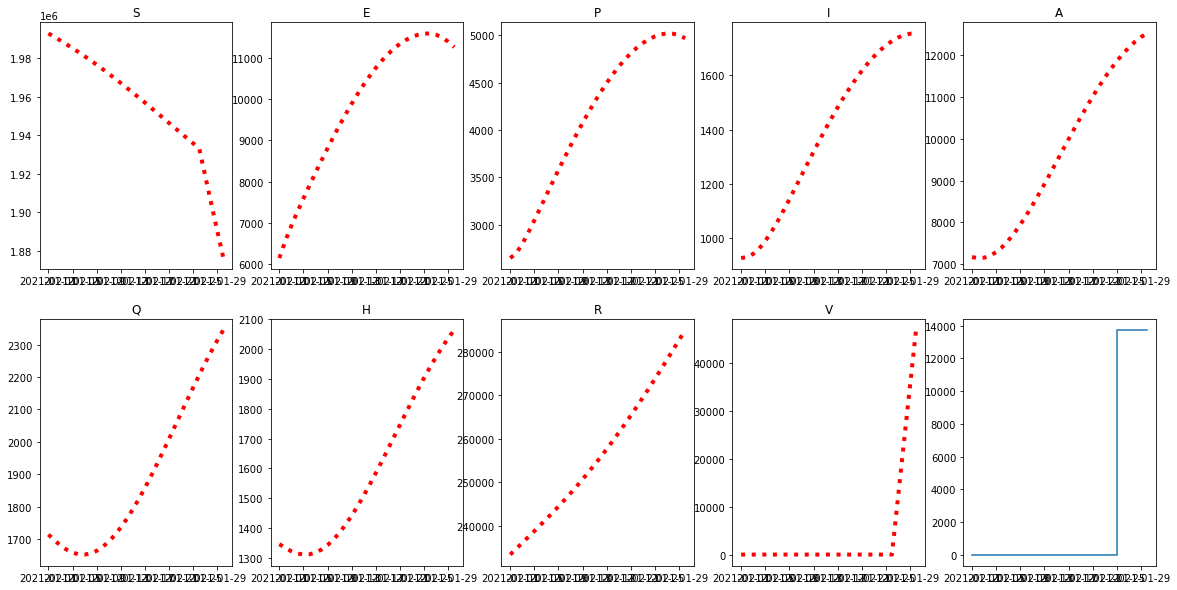

In [4]:
fig, axes = plt.subplots(2,5, figsize = (20,10))
fig.patch.set_facecolor('white')

nd = 0

for i, st in enumerate(states_names):
    axes.flat[i].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == nd)]['value'], linestyle=':', lw = 4, color='r')
    if myopt is not None:
        axes.flat[i].plot(myopt[(myopt['comp'] == st) & (myopt['placeID'] == nd)]['value'], linestyle='--', lw = 2, color='g')
    #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[nd,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'].index,
                   mydata[(mydata['comp'] == 'vacc') & (mydata['placeID'] == nd)]['value'], label=r"$\nu(t)$");
if myopt is not None:
    axes.flat[-1].step(myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'].index,
                       myopt[(mydata['comp'] == 'vacc') & (myopt['placeID'] == nd)]['value'], label=r"$\nu(t)$");

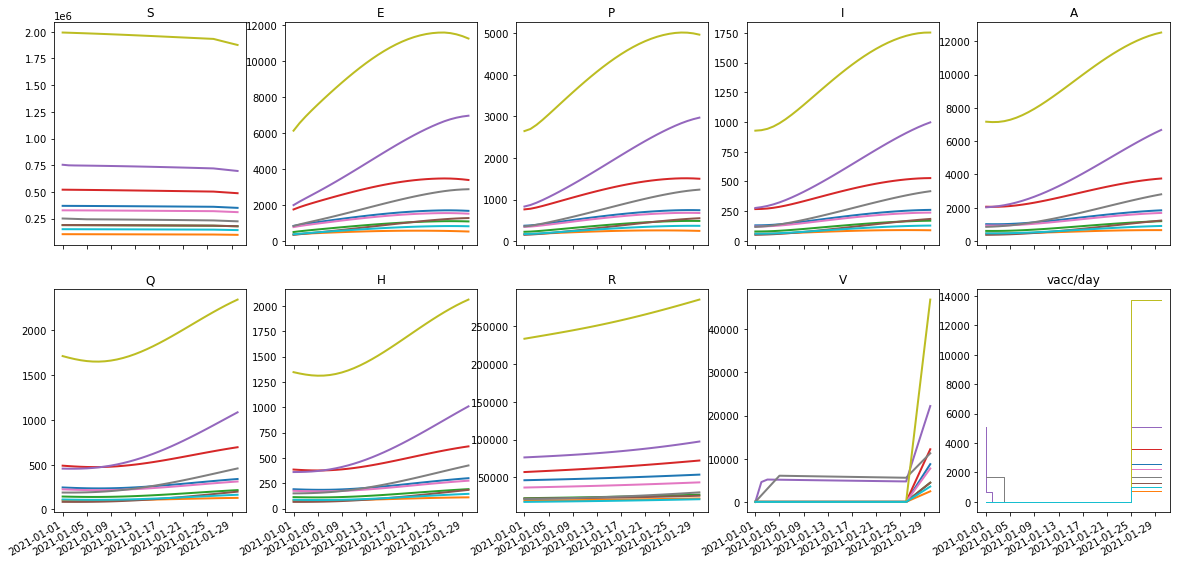

In [145]:
fig, axes = plt.subplots(2,5, figsize = (20,10), sharex=True)

value = 'value'
with sns.color_palette(n_colors=107):   # cycle 10
    for i, st in enumerate(states_names):
        axes.flat[i].plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 2, ls = '-')
        #axes.flat[i].plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '-')
        #for k in range(M):

        #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-.', lw = .5)
        axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).index,
    mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value), lw = 1, ls = '-');

#axes.flat[-1].step(myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    #myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 2);
axes.flat[-1].set_title('vacc/day')
fig.autofmt_xdate()

In [ ]:
len(setup.pop_node[mydata['placeID']])

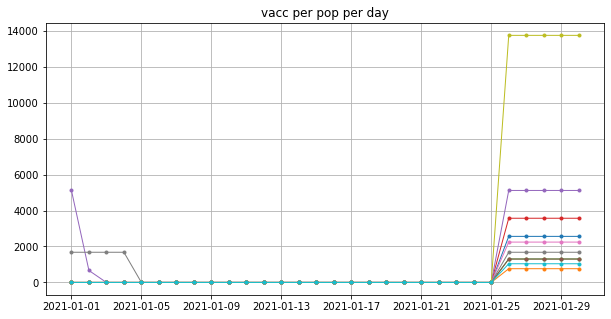

In [149]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 1, ls = '-', marker='.')
#ax.plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values=value), lw = 3, ls = '', marker='x')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st + ' per pop per day');
ax.grid()

In [30]:
ndays

25

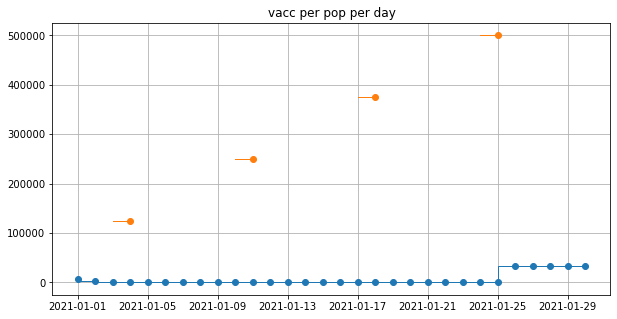

In [8]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index,
        mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).sum(axis=1), lw = 1, ls = '-', marker='o')
ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index[:-1],  stockpile_national_constraint, lw = 1, ls = '-', marker='o')
#ax.plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values=value), lw = 3, ls = '', marker='x')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st + ' per pop per day');
ax.grid()
#ax.set_ylim(0)

In [9]:
stockpile_national_constraint

array([    inf,     inf,     inf, 125000.,     inf,     inf,     inf,
           inf,     inf,     inf, 250000.,     inf,     inf,     inf,
           inf,     inf,     inf, 375000.,     inf,     inf,     inf,
           inf,     inf,     inf, 500000.,     inf,     inf,     inf,
           inf])

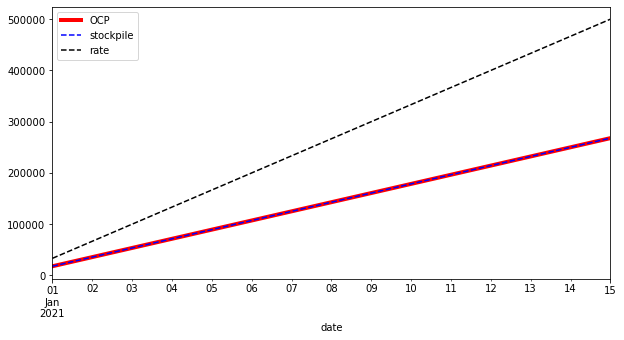

In [65]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).cumsum().plot(c = 'r', lw = 4, label = 'OCP')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*dosesperweek/7), c='b', ls='--', label='stockpile')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*ratepermonth/30), c='k', ls='--', label = 'rate')
ax.legend()
#ax.set_ylim(0,1e6)

In [ ]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white', sharey=True)
#fig, axes = plt.subplots(5,2, figsize = (20,10), sharex=True)#, sharey=True)
import seaborn as sns
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    #axes.flat[k].bar(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'].index,
    #                 mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], #linestyle='-', lw = 3,  marker='', 
    #                 color='orange')
    axes.flat[k].plot(mydata[(mydata['comp'] == st) & (mydata['placeID'] == k)]['value'], linestyle='-', lw = 2, color='r')#, marker='.')

    
    axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,i], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    #axes.flat[k].set_ylim(0,5000)
fig.autofmt_xdate()

# Compare scenarios

In [ ]:
scenarios = [ 'U', 'L'] # 'U', 'C' 
mydata = {}
for scn in scenarios:
    mydata[scn] = pd.read_csv(f'model_output/{scn}-r1-t75000-int107-120-nc.csv', index_col= 'date', parse_dates=True)

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (15,7), facecolor = 'white')
i = 3
st = states_names[i]
print(st)

for scn in scenarios:
    md = mydata[scn]
    axes.plot(md[(md['comp'] == st)].groupby('date').sum()['value'], linestyle='-', lw = 2, label = scn)
axes.set_title(st)
    
axes.legend()
fig.autofmt_xdate()

In [ ]:
md[(md['comp'] == st)].groupby('date').sum()['value']

In [ ]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white')#, sharey=True)
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    for scn in scenarios:
        md = mydata[scn]
        axes.flat[k].plot(md[(md['comp'] == st) & (md['placeID'] == k)]['value'], linestyle='-', lw = 2, label = scn)
    axes.flat[k].set_title(nname)
    
axes.flat[0].legend()
fig.autofmt_xdate()

In [ ]:
import scipy
course = scipy.interpolate.interp1d([0, 50, 100, 1000], [.75, .85, .45,.45], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100], [.75, .85, .45], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100], [1.3, .7, 2], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100, 100000], [1.3, .7, 2, 2], kind='linear')
course = course(np.arange(0,  250))
plt.plot(course)

In [ ]:
scipy.interpolate.interp1d?

# All TS analysis

In [10]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import glob

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q','H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'week'
myopt = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [11]:
outdir = '2021-01-15-107_90/'
file_list = glob.glob(outdir + '*.csv')
#outdir = '2021-01-14_nanoechopc/'
#file_list = glob.glob(outdir + 'microechopc*.csv')
file_list = [fn for fn in file_list if 'opt' in fn]
file_list.sort()
print(len(file_list))

21


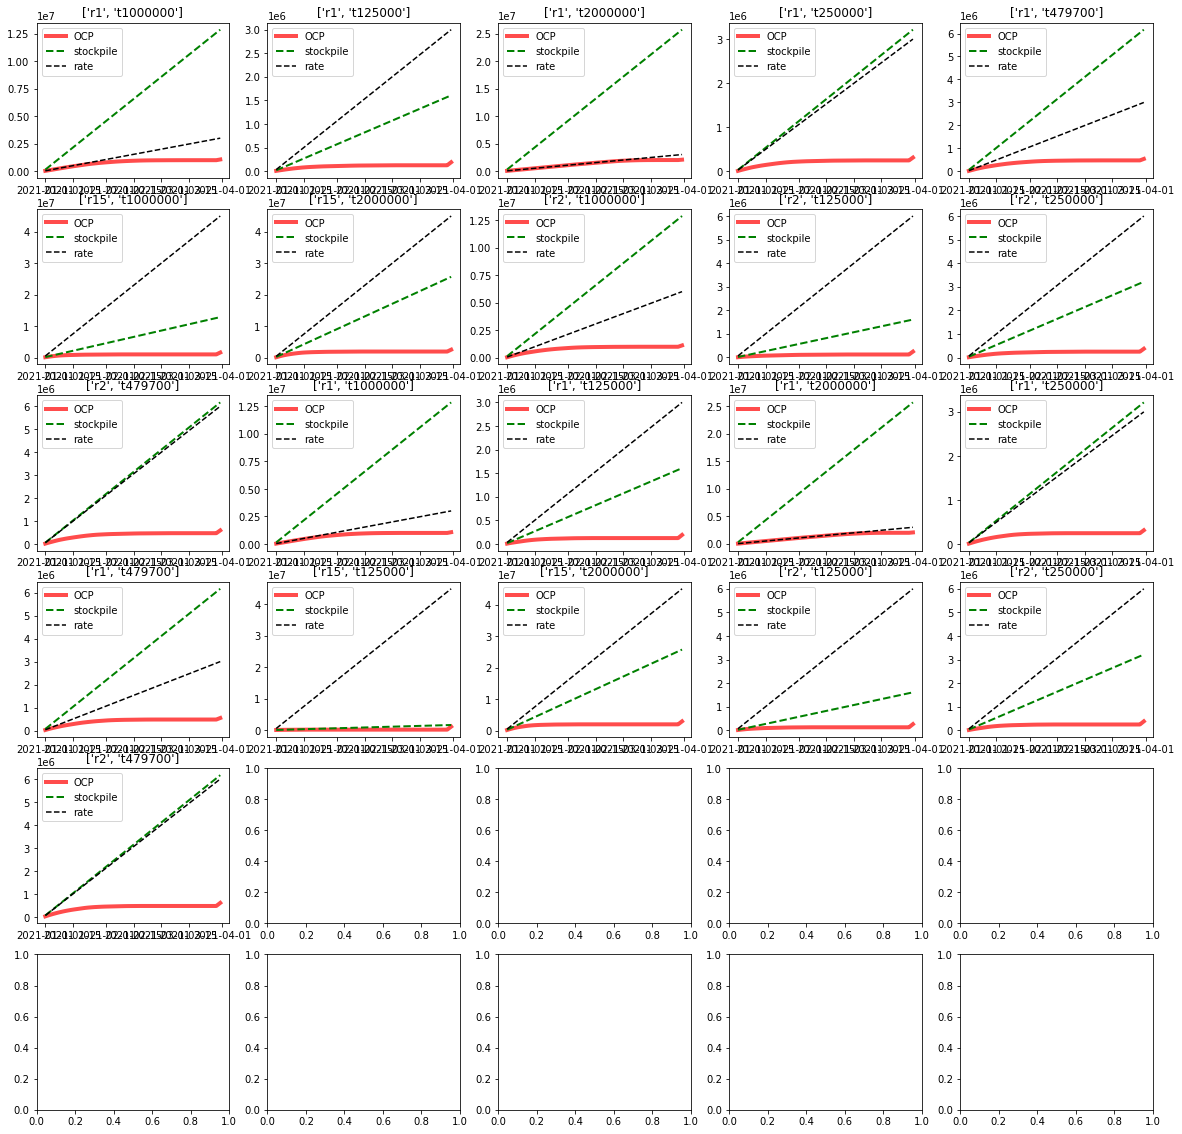

In [13]:
value = 'value'
fig, ax = plt.subplots(6,5,figsize=(20,20))#, sharex = True, sharey = True)
fig.set_facecolor('white')
ax = [ax for ax in ax.flat]

for i, filename in enumerate(file_list):
    mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
    mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

    dosesperweek = float(filename.split('-')[-3][1:])
    ratepermonth = float(filename.split('-')[-4][1:])*1e6
    
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).cumsum(),
               c = 'r', lw = 4, label = 'OCP', alpha = .7)
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.cumsum(np.ones(ndays)*dosesperweek/7), c='g', lw=2, ls='--', label='stockpile')
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.cumsum(np.ones(ndays)*ratepermonth/30), c='k', ls='--', label = 'rate')
    
    ax[i].legend()
    #ax[i].set_ylim(0, 1e4)
    ax[i].set_title(filename.split('-')[-4:-2])

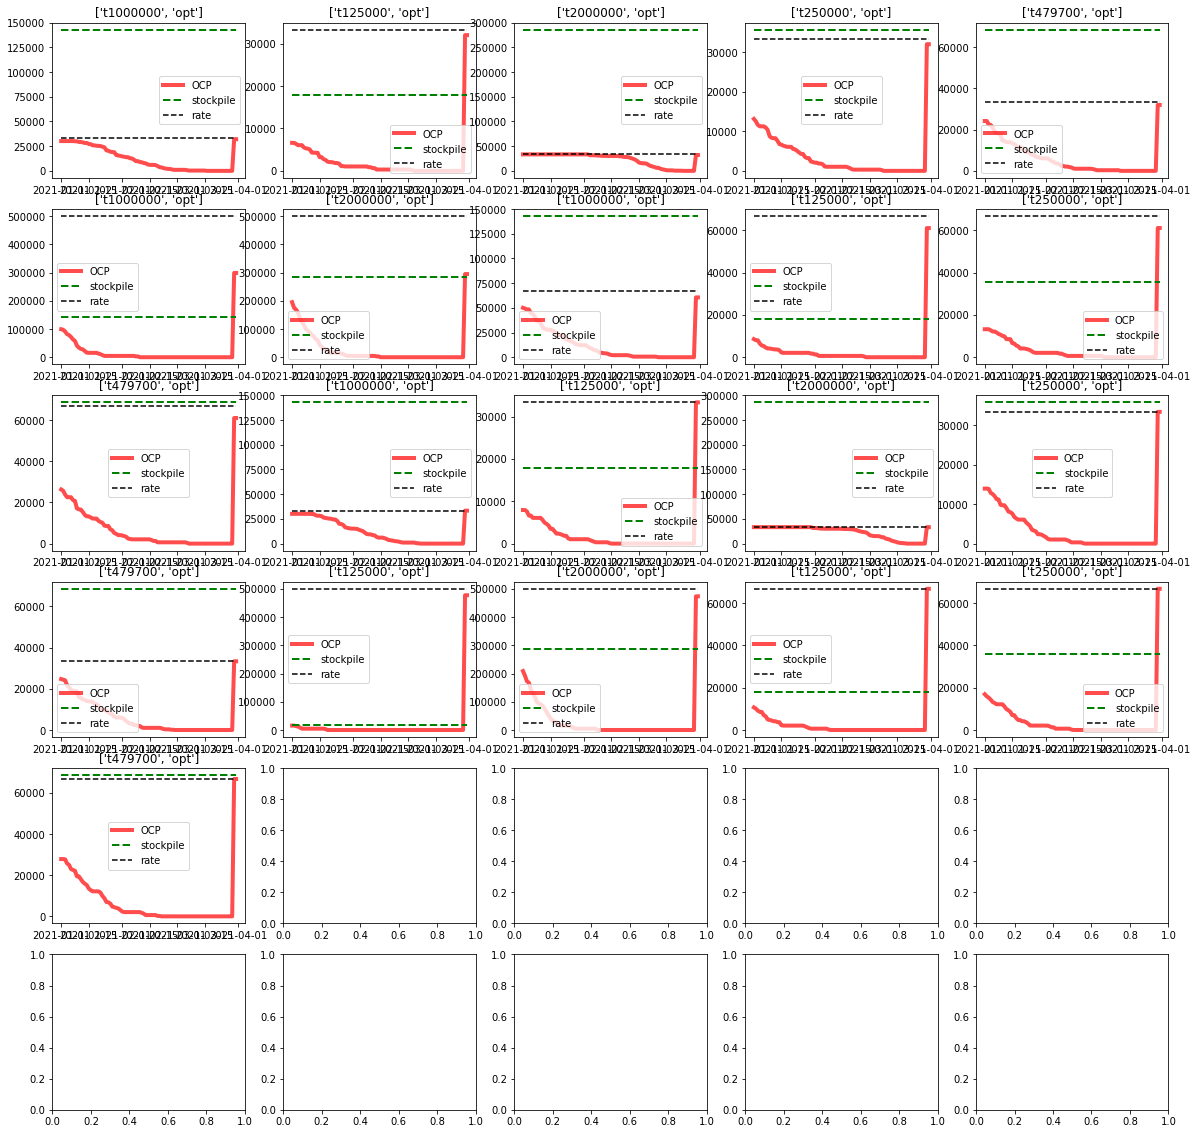

In [14]:
value = 'value'
fig, ax = plt.subplots(6,5,figsize=(20,20))#, sharex = True, sharey = True)
fig.set_facecolor('white')
ax = [ax for ax in ax.flat]

for i, filename in enumerate(file_list):
    mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
    mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]

    dosesperweek = float(filename.split('-')[-3][1:])
    ratepermonth = float(filename.split('-')[-4][1:])*1e6
    
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1),
               c = 'r', lw = 4, label = 'OCP', alpha = .7)
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.ones(ndays)*dosesperweek/7, c='g', lw=2, ls='--', label='stockpile')
    ax[i].plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, 
               np.ones(ndays)*ratepermonth/30, c='k', ls='--', label = 'rate')
    
    ax[i].legend()
    #ax[i].set_ylim(0, 1e6)
    ax[i].set_title(filename.split('-')[-3:-1])

In [ ]:
a =ocp.g(ocp.arg['ubg'])
b = np.array(a['vaccines'])

In [42]:

with open(f'2021-01-14_micro/2021-01-14_micro-L-r1-t125000-opt-107_25_lamg.pkl', 'rb') as inp:
    lamg = pickle.load(inp)
with open(f'2021-01-11-tiny/2021-01-11_tinyL-r1-t125000-opt107_45_lamx.pkl', 'rb') as inp:
    lamx = pickle.load(inp)


RuntimeError: map::at:  key not found

In [179]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f'2021-01-11_tiny'
outdir = '2021-01-11-tiny/'

myopt = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 15

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)
    
filename = 'model_output/L-r15-t125000-opt107_15.csv'
mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
mydata['valuepop'] = mydata['value'] / setup.pop_node[mydata['placeID']]
mydata[mydata['value']<0]

dosesperweek = int(filename.split('-')[-2][1:])
ratepermonth = int(filename.split('-')[-3][1:])*1e6

Loaded Italy Setup with 107 nodes.


125000

(0.0, 18749.99999999951)

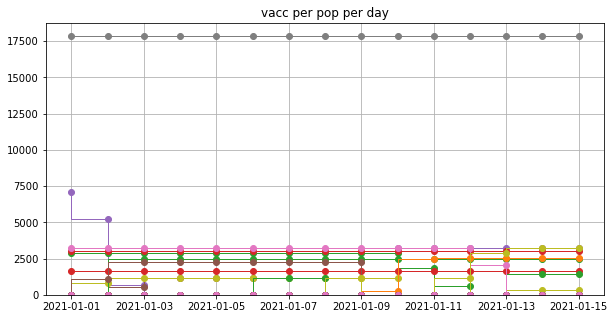

In [180]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
i = 8
st = states_names[i]
st = 'vacc'
value = 'value'

ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index,
        mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 1, ls = '-', marker='o')
ax.step(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value).index,
        np.ones(ndays)*dosesperweek/7, lw = 1, ls = '-', marker='o')
#ax.plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values=value), lw = 3, ls = '', marker='x')

#ax.plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-', lw = .5)
ax.set_title(st + ' per pop per day');
ax.grid()
ax.set_ylim(0)

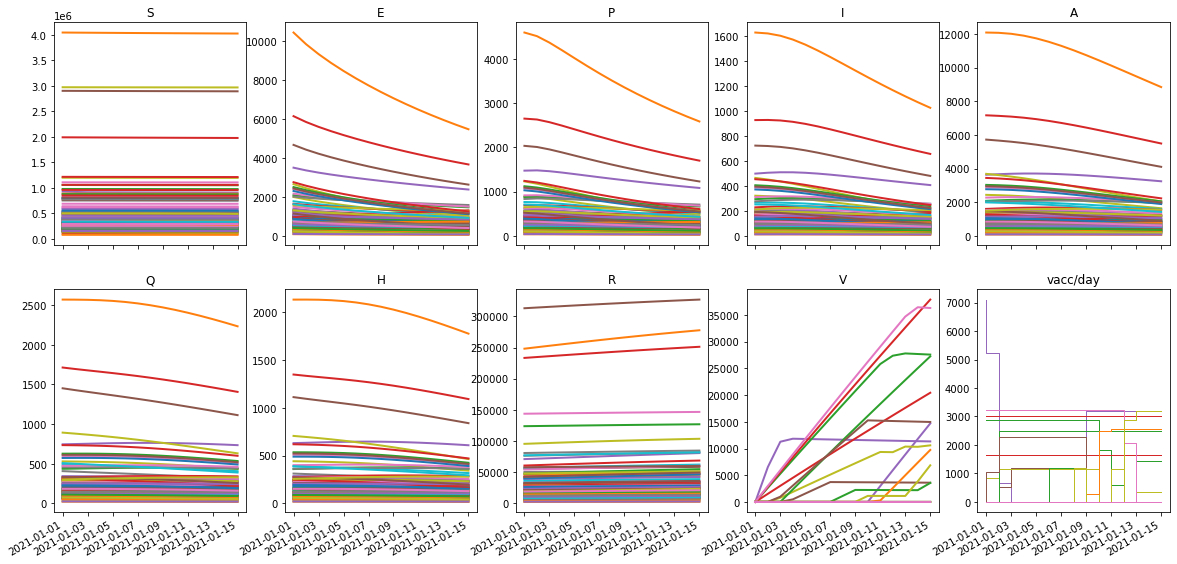

In [181]:
fig, axes = plt.subplots(2,5, figsize = (20,10), sharex=True)

value = 'value'
with sns.color_palette(n_colors=107):   # cycle 10
    for i, st in enumerate(states_names):
        axes.flat[i].plot(mydata[(mydata['comp'] == st)].pivot(columns = 'place', values=value), lw = 2, ls = '-')
        #axes.flat[i].plot(myopt[(myopt['comp'] == st)].pivot(columns = 'place', values='value'), lw = 2, ls = '-')
        #for k in range(M):

        #axes.flat[i].plot(p.matlab_model_days, p.matlab_initial[:,:,i].T, linestyle='-.', lw = .5)
        axes.flat[i].set_title(st);

axes.flat[-1].step(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).index,
    mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value), lw = 1, ls = '-');

#axes.flat[-1].step(myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value').index,
    #myopt[(myopt['comp'] == 'vacc')].pivot(columns = 'place', values='value'), lw = 2);
axes.flat[-1].set_title('vacc/day')
fig.autofmt_xdate()

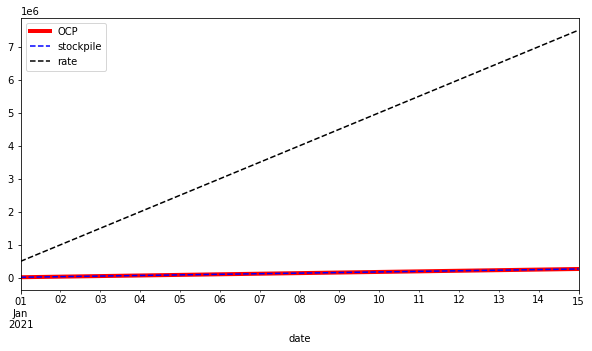

In [184]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).cumsum().plot(c = 'r', lw = 4, label = 'OCP')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*dosesperweek/7), c='b', ls='--', label='stockpile')
ax.plot(mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis=1).index, np.cumsum(np.ones(ndays)*ratepermonth/30), c='k', ls='--', label = 'rate')
ax.legend()
#ax.set_ylim(0,5e5)

In [123]:
np.cumsum(np.ones(ndays)*dosesperweek/7)

array([ 17857.14285714,  35714.28571429,  53571.42857143,  71428.57142857,
        89285.71428571, 107142.85714286, 125000.        , 142857.14285714,
       160714.28571429, 178571.42857143, 196428.57142857, 214285.71428571,
       232142.85714286, 250000.        , 267857.14285714])

In [125]:
a = [0]*10

In [150]:
mydata[(mydata['comp'] == 'vacc')].pivot(columns = 'place', values=value).sum(axis = 1)

date
2021-01-01     16666.666726
2021-01-02     33333.333368
2021-01-03     50000.000071
2021-01-04     66666.666731
2021-01-05     83333.333379
2021-01-06    100000.000205
2021-01-07    116666.666700
2021-01-08    133333.333488
2021-01-09    150000.000353
2021-01-10    166666.667264
2021-01-11    183333.334278
2021-01-12    200000.001551
2021-01-13    216666.668721
2021-01-14    233333.332203
2021-01-15    233333.332203
dtype: float64

In [127]:
a[0] += 2

In [132]:
a[3] = a[3]+4

In [147]:
mydata[(mydata['comp'] == 'vacc')].loc['2021-01-15']

,comp,place,value,placeID,valuepop
date,,,,,
2021-01-15,vacc,Torino,18717.001024,0,8.283692e-03
2021-01-15,vacc,Vercelli,1415.756730,1,8.283639e-03
2021-01-15,vacc,Novara,3056.832277,2,8.283649e-03
2021-01-15,vacc,Cuneo,4863.352530,3,8.283687e-03
2021-01-15,vacc,Asti,1778.004714,4,8.283660e-03
...,...,...,...,...,...
2021-01-15,vacc,Verbano-Cusio-Ossola,1311.707371,102,8.283596e-03
2021-01-15,vacc,Monza e della Brianza,0.017395,103,1.990467e-08
2021-01-15,vacc,Fermo,1439.702282,104,8.283673e-03
